## Load modules and import dataset with pandas


In [1]:
# utility
import pandas
import numpy as np
from scipy.io import arff
# plot
import seaborn as sns
import matplotlib.pyplot as plt
# sklearn
from sklearn.preprocessing import KBinsDiscretizer

dataset = arff.loadarff('./data/ames_housing.arff')
data = pandas.DataFrame(dataset[0])
len(data.columns)

%store data

data.describe().transpose()

Stored 'data' (DataFrame)


,count,mean,std,min,25%,50%,75%,max
Lot_Frontage,2930.0,57.647782,33.499441,0.000000,43.000000,63.000000,78.000000,313.000000
Lot_Area,2930.0,10147.921843,7880.017759,1300.000000,7440.250000,9436.500000,11555.250000,215245.000000
Year_Built,2930.0,1971.356314,30.245361,1872.000000,1954.000000,1973.000000,2001.000000,2010.000000
Year_Remod_Add,2930.0,1984.266553,20.860286,1950.000000,1965.000000,1993.000000,2004.000000,2010.000000
Mas_Vnr_Area,2930.0,101.096928,178.634545,0.000000,0.000000,0.000000,162.750000,1600.000000
BsmtFin_SF_1,2930.0,4.177474,2.233372,0.000000,3.000000,3.000000,7.000000,7.000000
BsmtFin_SF_2,2930.0,49.705461,169.142089,0.000000,0.000000,0.000000,0.000000,1526.000000
Bsmt_Unf_SF,2930.0,559.071672,439.540571,0.000000,219.000000,465.500000,801.750000,2336.000000
Total_Bsmt_SF,2930.0,1051.255631,440.968018,0.000000,793.000000,990.000000,1301.500000,6110.000000
First_Flr_SF,2930.0,1159.557679,391.890885,334.000000,876.250000,1084.000000,1384.000000,5095.000000


In [2]:
def refineData(df):
    replace_kitch = {
        "Kitchen_Qual": {b'Poor': 0, b'Fair': 1, b'Typical': 2, b'Good': 3, b'Excellent': 4},
        "Utilities": {b'AllPub': 1, b'NoSewr': 2, b'NoSeWa': 3},
        "Land_Slope": {b'Gtl': 1, b'Mod': 2, b'Sev': 3}
    }
    data = df.replace(replace_kitch)
    return data


data = refineData(data)

print(data.Land_Slope.value_counts())
print(data.Kitchen_Qual.value_counts())
print(data.Utilities.value_counts())
#print(data.MS_Zoning.value_counts())
#print(data.MS_SubClass.value_counts())

1    2789
2     125
3      16
Name: Land_Slope, dtype: int64
2    1494
3    1160
4     205
1      70
0       1
Name: Kitchen_Qual, dtype: int64
1    2927
2       2
3       1
Name: Utilities, dtype: int64


## Controllo features

Andiamo a vedere le caratteristiche di alcune feature.

In [3]:
for i in data.loc[:, ~data.columns.isin(data._get_numeric_data())]:
    print()
    print(data[i].value_counts())


b'One_Story_1946_and_Newer_All_Styles'          1079
b'Two_Story_1946_and_Newer'                      575
b'One_and_Half_Story_Finished_All_Ages'          287
b'One_Story_PUD_1946_and_Newer'                  192
b'One_Story_1945_and_Older'                      139
b'Two_Story_PUD_1946_and_Newer'                  129
b'Two_Story_1945_and_Older'                      128
b'Split_or_Multilevel'                           118
b'Duplex_All_Styles_and_Ages'                    109
b'Two_Family_conversion_All_Styles_and_Ages'      61
b'Split_Foyer'                                    48
b'Two_and_Half_Story_All_Ages'                    23
b'One_and_Half_Story_Unfinished_All_Ages'         18
b'PUD_Multilevel_Split_Level_Foyer'               17
b'One_Story_with_Finished_Attic_All_Ages'          6
b'One_and_Half_Story_PUD_All_Ages'                 1
Name: MS_SubClass, dtype: int64

b'Residential_Low_Density'         2273
b'Residential_Medium_Density'       462
b'Floating_Village_Residential'     13

Cerchiamo le feature categoriche che hanno un valore in cui occorrono il 95% delle istanze o più.

In [4]:
for i in data.loc[:, ~data.columns.isin(data._get_numeric_data())]:
    if data[i].value_counts()[0] * 100 / len(data[i]) >= 95:
        print(i)

Street
Condition_2
Roof_Matl
Heating
Pool_QC
Misc_Feature


count        2930
unique          6
top       b'None'
freq         2824
Name: Misc_Feature, dtype: object

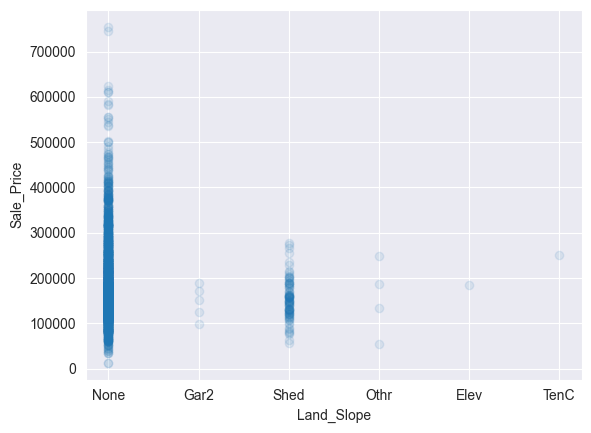

In [5]:
fig, axs = plt.subplots()

axs.plot(data.Misc_Feature, data['Sale_Price'], 'o', alpha=0.1)
axs.set_xlabel('Land_Slope')
axs.set_ylabel('Sale_Price')

data.Misc_Feature.describe()

La feature `Street` non ha una distribuzione uniforme tra le varie classi e non va ha un prezzo interessante rispetto a quello di "Pave", quindi non ha un buon valore predittivo.

La feature `Utilities` non ha una distribuzione uniforme tra le varie classi e non va ha un prezzo interessante rispetto a quello di "Pave", quindi non ha un buon valore predittivo.

Andiamo momentaneamente ad escludere le seguenti feature:
- Street
- Utilities
- Land_Slope
- Condition_2
- Roof_Matl
- Heating
- Pool_QC
- Misc_Feature

In quanto il 95% delle istanze cadono nello stesso valore della feature

# Discretizzazzione del prezzo
Andiamo a `discretizzare` i valori del prezzo per rendere il problema di classificazione.
Il metodo fornito dalla libreria sklearn fornisce tre diverse strategie di discretizzazione.

Edges uniform strategy:
[ 12789.   87010.1 161231.2 235452.3 309673.4 383894.5 458115.6 532336.7
 606557.8 680778.9 755000. ]


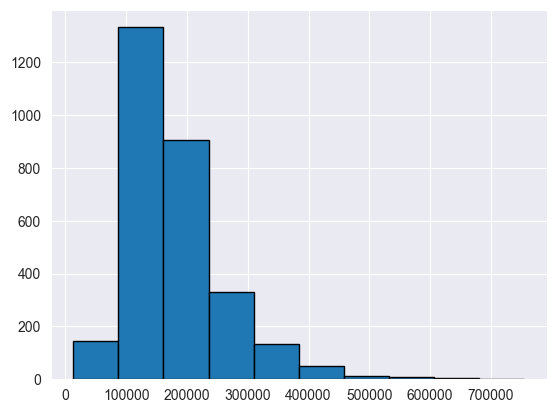

Edges quantile strategy:
[ 12789.  105450.  124000.  135000.  146500.  160000.  178536.  199500.
 230000.  281241.7 755000. ]


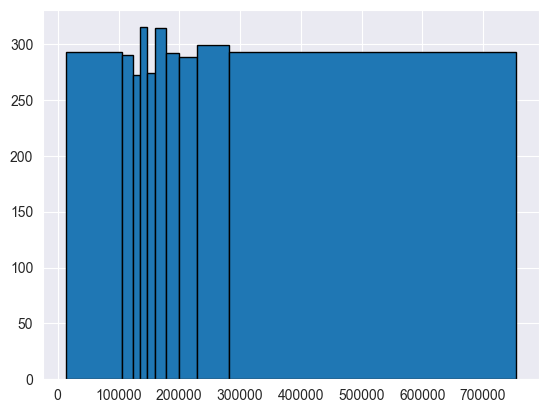

Edges kmeans strategy:
[ 12789.         113547.8517015  155070.87017883 196143.46500466
 240910.97167506 291558.52164206 351900.9195098  421710.69816092
 517725.34482759 663557.         755000.        ]


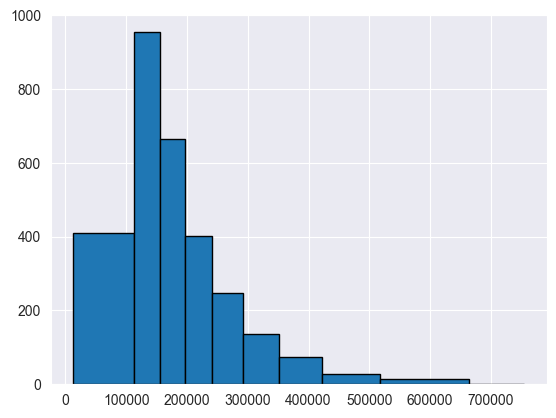

In [6]:
Y = data['Sale_Price'].to_numpy()
Y = Y.reshape(-1, 1)

for strategy in ["uniform", "quantile", "kmeans"]:
    enc = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy=strategy)
    Y_binned = enc.fit_transform(Y)

    print("Edges " + strategy + " strategy:")
    print(enc.bin_edges_[0])

    plt.hist(Y, enc.bin_edges_[0], edgecolor="black")
    plt.show()

# Controlliamo se vi sono dati mancanti
Come possiamo vedere non vi sono missing values per le features.

In [7]:
data.isnull().sum().sort_values()

MS_SubClass     0
Garage_Type     0
Fireplace_Qu    0
Fireplaces      0
Functional      0
               ..
Exterior_2nd    0
Exterior_1st    0
Roof_Matl       0
Heating_QC      0
Latitude        0
Length: 81, dtype: int64

## Plotting
dist plot delle feature numeriche

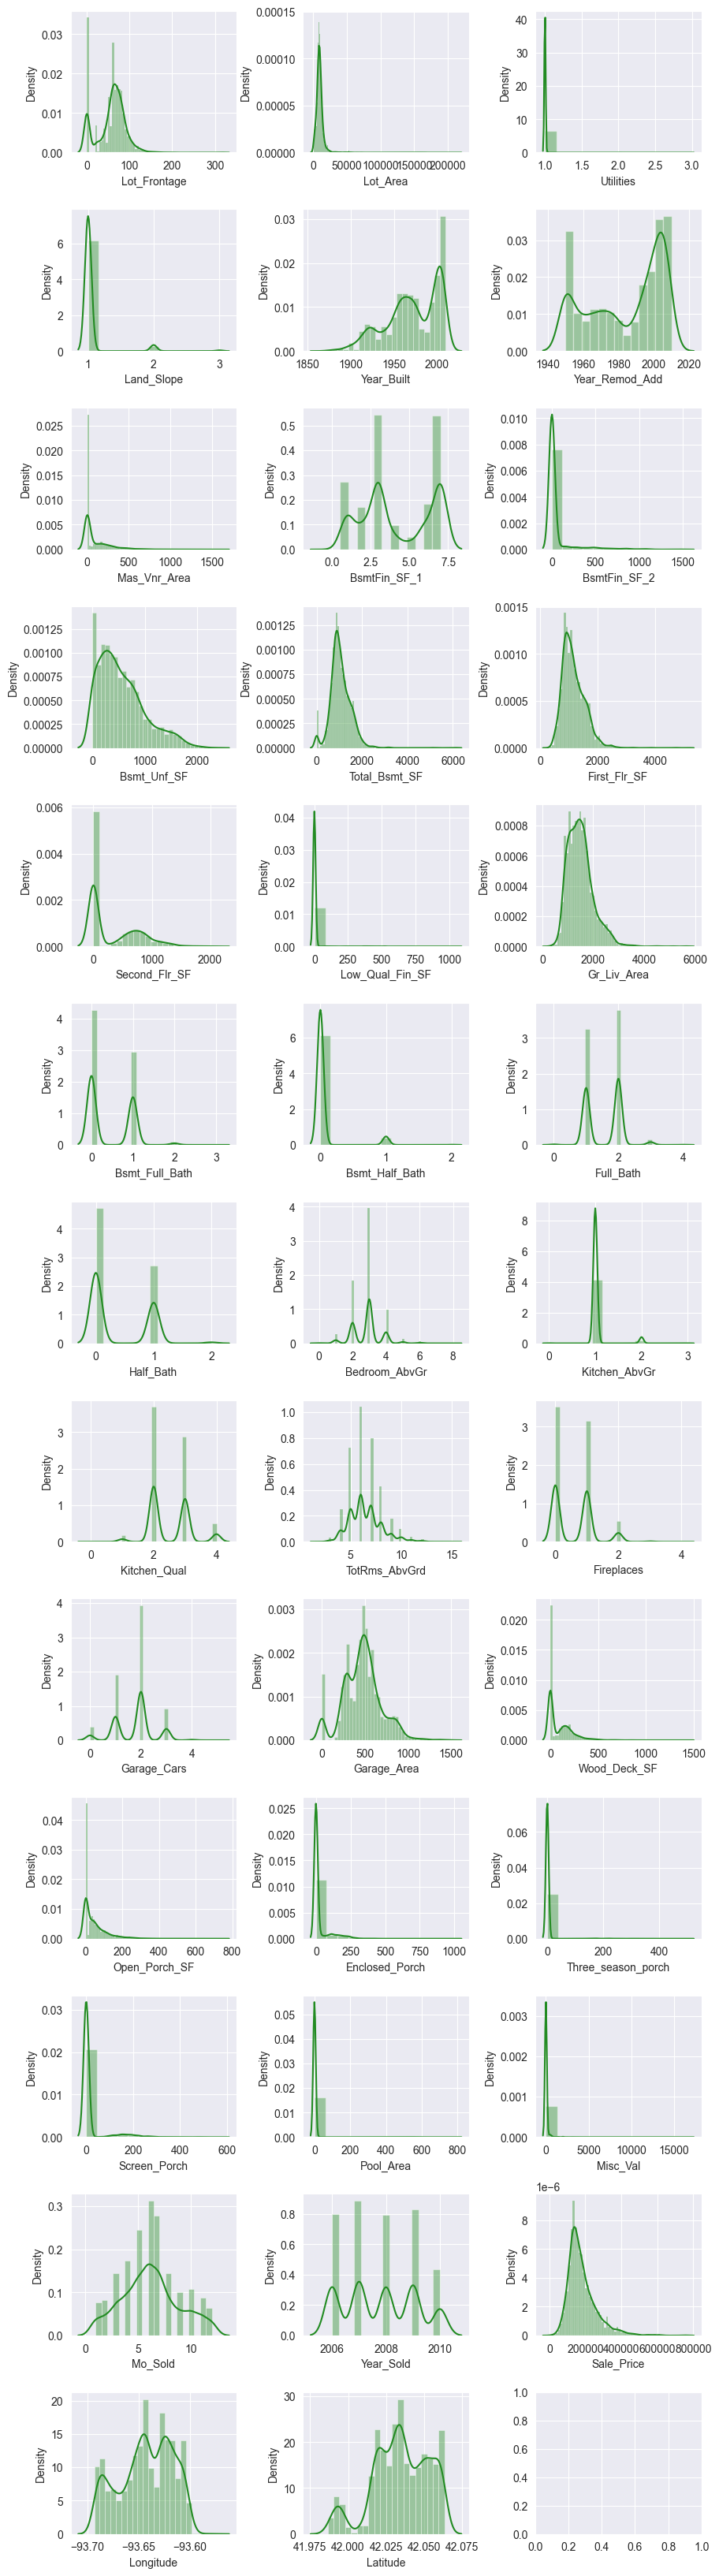

In [8]:
# get numerical features
numeric_features = data._get_numeric_data()
# print(len(numeric_features.columns))

fig, axes = plt.subplots(nrows=13, ncols=3)
axes = axes.flatten()
fig.set_size_inches(10, 40)
fig.tight_layout()

for ax, col in zip(axes, numeric_features.columns):
    sns.histplot(
        numeric_features[col], kde=True,
        stat="density", kde_kws=dict(cut=3),
        alpha=.4, edgecolor=(1, 1, 1, .4), ax=ax, color='forestgreen'
    )

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

Plottiamo tutte le feature in relazione al prezzo di vendita per avere un'idea della loro importanza.

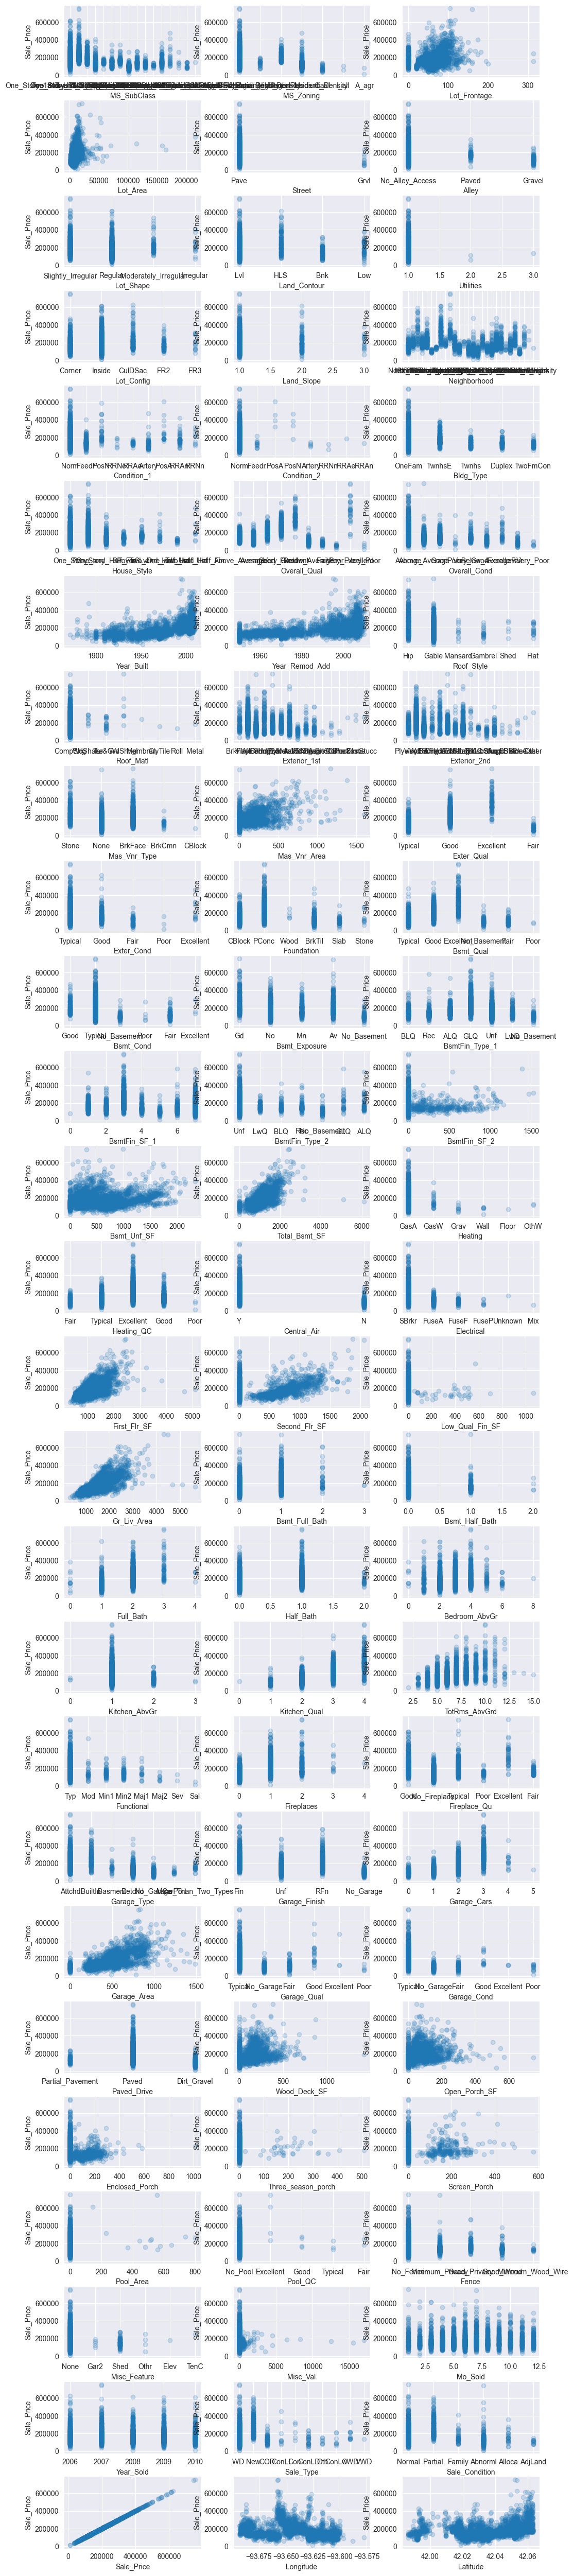

In [9]:
fig, axes = plt.subplots(nrows=27, ncols=3)
axes = axes.flatten()
fig.set_size_inches(10, 50)
fig.tight_layout()

for ax, col in zip(axes, data.columns):
    ax.plot(data[col], data['Sale_Price'], 'o', alpha=0.2)
    ax.set_xlabel(col)
    ax.set_ylabel('Sale_Price')

plt.show()

In [10]:
print(data.MS_Zoning.value_counts())


b'Residential_Low_Density'         2273
b'Residential_Medium_Density'       462
b'Floating_Village_Residential'     139
b'Residential_High_Density'          27
b'C_all'                             25
b'I_all'                              2
b'A_agr'                              2
Name: MS_Zoning, dtype: int64


# Price graph for lat-long

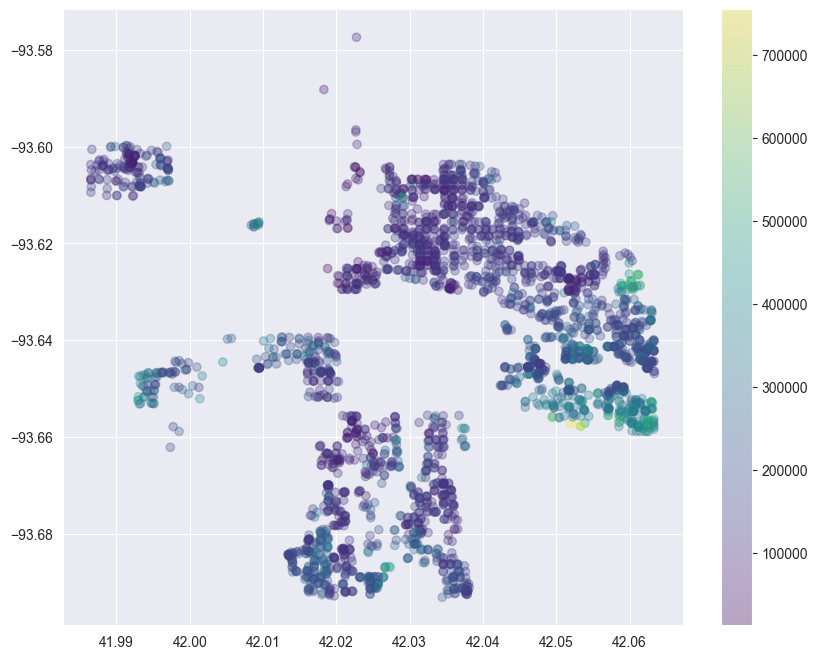

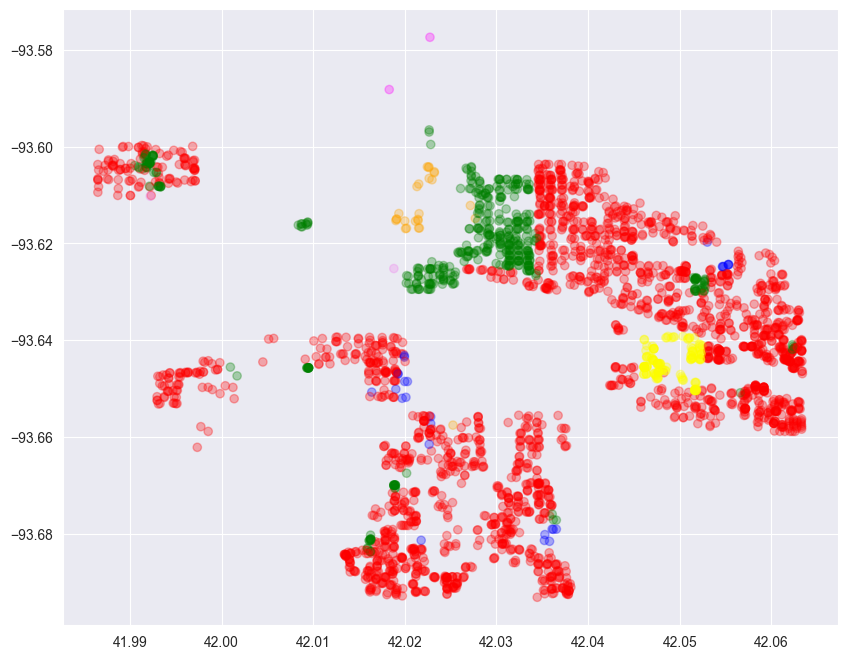

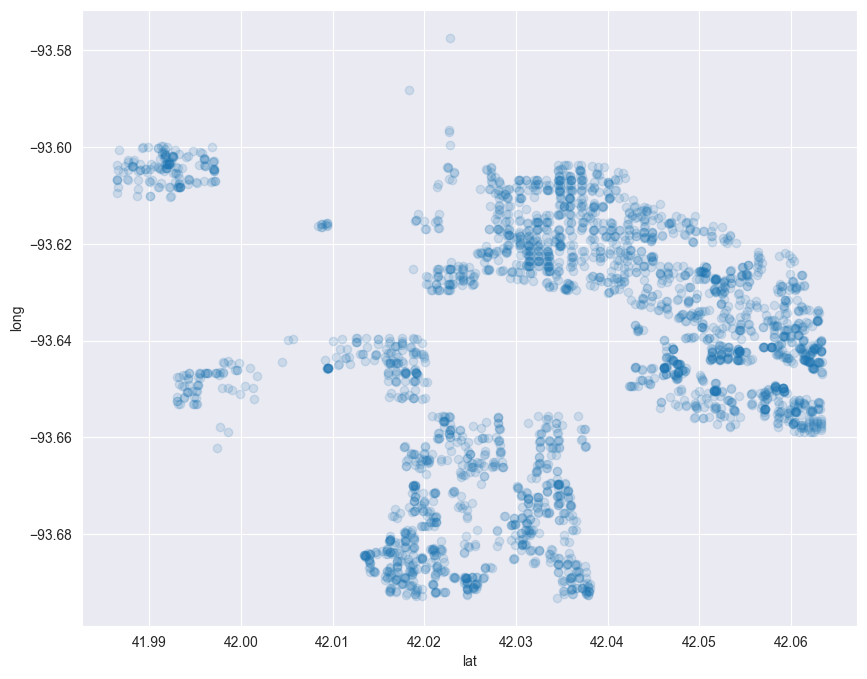

In [11]:
fig, axs = plt.subplots(figsize=(10, 8))

pos = plt.scatter(data.Latitude, data.Longitude, c = data.Sale_Price, cmap="viridis", alpha=0.3)
fig.colorbar(pos)
plt.savefig('./plots/books_read.png')
plt.show()

fig, axs = plt.subplots(figsize=(10, 8))

clr = {b'Residential_Low_Density': 'red', b'Residential_Medium_Density': 'green', b'Floating_Village_Residential':'yellow', b'Residential_High_Density':'blue', b'C_all':'orange', b'I_all':'magenta',b'A_agr':'violet'}

pos = plt.scatter(data.Latitude, data.Longitude, c = data.MS_Zoning.map(clr), alpha=0.3)
plt.savefig('./plots/books_read.png')
plt.show()

fig, axs = plt.subplots(figsize=(10, 8))

axs.plot(data.Latitude, data.Longitude, 'o', alpha=0.15)
axs.set_xlabel('lat')
axs.set_ylabel('long')
plt.show()

Fare clustering sulla descritizazione del prezzo, usandolo come etichetta.
DBSCAN??? guardare vecchio notebook

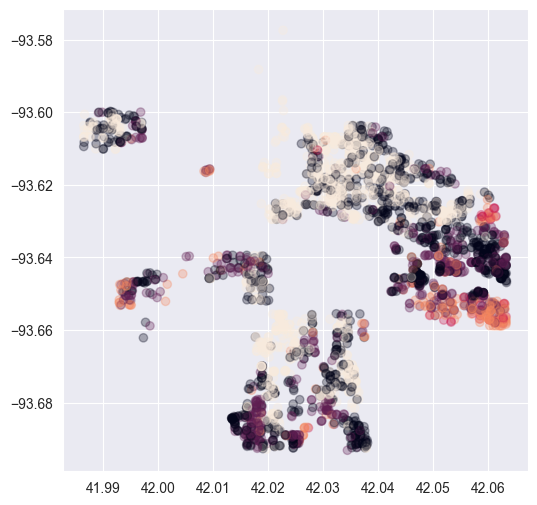

In [12]:
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans


X=data[["Latitude","Longitude","Sale_Price"]]

# create cluster
kNN = KMeans(n_clusters=5)

kNN.fit(X, data.Sale_Price)

z_labels = kNN.predict(X)

# plot
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(data.Latitude, data.Longitude, c=z_labels, alpha=0.3)
#ax.scatter(data.Latitude, data.Longitude, c=z_labels, marker='+', alpha=0.3)


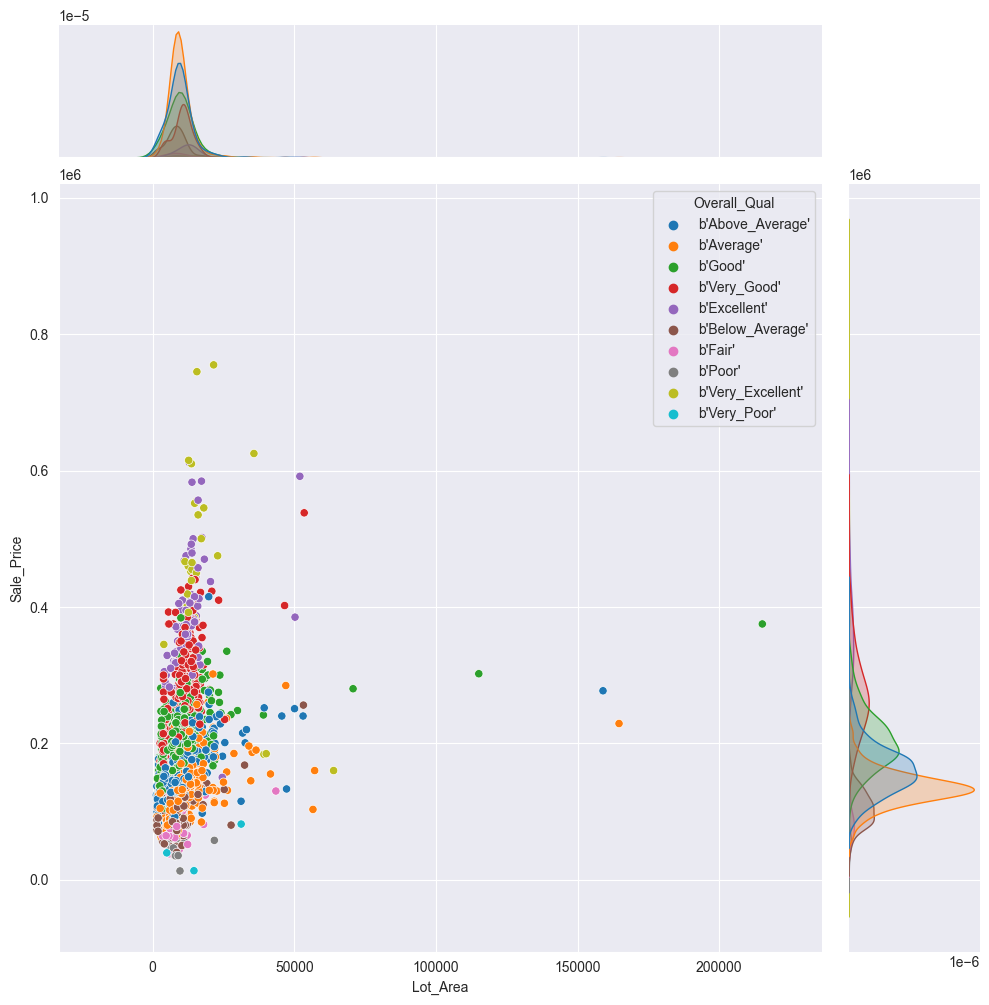

In [13]:
sns.jointplot(
    data=data,
    x="Lot_Area", y="Sale_Price", hue="Overall_Qual",
    height=10
) # kind="kde"

C:\Users\david\py_venvs\progetto_DWM_venv\lib\site-packages\seaborn\distributions.py:1185: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


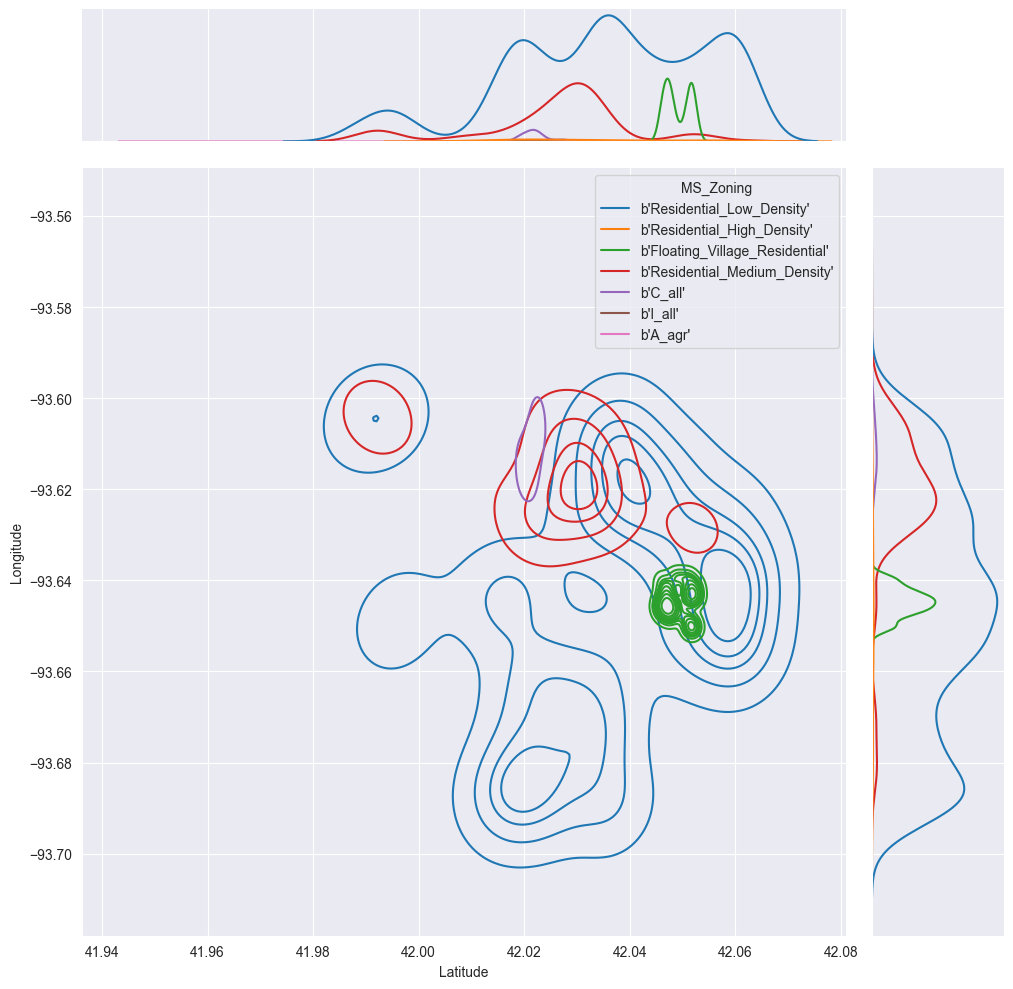

In [14]:
sns.jointplot(
    data=data,
    x="Latitude", y="Longitude", hue="MS_Zoning",
    height=10,
    kind="kde"
) # kind="kde"